In [1]:
# Imports as always.
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dataclasses
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from PIL import Image

from hflayers import Hopfield, HopfieldLayer, HopfieldPooling

from datetime import datetime

from tqdm.notebook import tqdm

from data_handling import ISICDataset

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121


# Hopfield as Pre-processing

This notebook considers the use of the new Hopfield layers as a pre-processing technique to preemptively reconstruct data for use in an otherwise standard pipeline.

We consider a few ways for going about this:
- **Pre-trained Hopfield**: The Hopfield pre-processing unit is independently pre-trained on a reconstructive task, then prepended onto a SegNet model for image segmentation. There is then some fine-tuning, wherein the SegNet's parameters are trained from scratch in tandem with the possibility for change in the Hopfield's parameters.
- **Pre-trained model**: The Hopfield pre-processing unit is prepended onto a model (SegNet) that has already been trained for image segmentation. Again, there is then a fine-tuning process. This is the setup we are most interested in practice, as we could train the SegNet on clean data to become competent at segmentation, then train the Hopfield + SegNet model on damaged data to understand whether it may be possible to recover performance by having a Hopfield learn to reconstruct damage. This setup also allows us to consider the implication of the Hopfield in isolation, uncovering the immediate effect of its introduction.
- **End-to-end training from scratch**: Again, we prepend a Hopfield pre-processing unit to a model (SegNet), though all weights are trained from scratch for the end-to-end image segmentation task. This is compatible with both train- and test-time reconstruction (unlike a pre-trained model, which is surely incapable of pre-training on damaged data). This is expected to be the worst performing variant, though success in this setup would be a fantastic result for memory-like pre-processing in neural networks.

From the original work, it is not entirely clear how to go about getting the Hopfield layers to do this. Let's discuss which layer seems most appropriate for this kind of reconstructive pre-processing.

### The `Hopfield` Layer

The `Hopfield` layer is designed for associating and processing two sets (equivalent to transformer attention, which associates keys and queries). In our case, this could be reduced to associating clean images (as stored keys) with damaged variants (as probing queries).

This is the most general form, where the result patterns $Z$ are functions of raw stored patterns $Y$, raw state patterns $R$, and possibly projection matrices $W_Q$, $W_K$, and $W_V$ (for query, key, and value). Specifically, 
$$
Z=\text{softmax}(\beta\cdot RW_QW_K^TY^T)YW_KW_V\ .
$$

The $N$ stored raw patterns $Y=(\mathbf{y}_1,\dots,\mathbf{y}_N)^T$ and the $S$ raw state patterns $R=(\mathbf{r}_1,\dots,\mathbf{r}_S)^T$ are mapped to an associative space (by matrices $W_K$ and $W_Q$). The flexibility of this layer (over transformers, for example) is that we may use *static* state and stored patterns -- they do not have to depend on network input.

Here is an illustration of the above equation (with $W_V:=W_KW_V$ for simplicity):

![Hopfield layer diagram](./hopfield_equation_diagram.png)

For this example, the implementation looks as follows:

```
hopfield = Hopfield(
    input_size = 3,                 # R
    hidden_size = 3,
    stored_pattern_size = 4,        # Y
    pattern_projection_size = 4,    # Y
    scaling = beta
)

# tuple of stored_pattern, state_pattern, pattern_projection.
hopfield((Y, R, Y))
```

### The `HopfieldPooling` Layer

The `HopfieldPooling` layer is designed for fixed pattern search, pooling operations, and memories like LSTMs or GRUs. The state (i.e. query) pattern is static, and may be learned during training.

If only one static state pattern (i.e. query) exists, the this is de facto a pooling over the sequence. This static state pattern is considered a "prototype pattern" and consequently learned in the Hopfield pooling layer. Note that the pooling always operates over the *token* dimension  (i.e. the sequence length), not the embedding dimension.

Here is an example of a pooling operation $Y\in\mathbb{R}^{(3\times5)}\to Z\in\mathbb{R}^{(2\times5)}$:

![Hopfield pooling diagram](./hopfield_pooling_diagram.png)

```
hopfield_pooling = HopfieldPooling(
    input_size=4,       # Y
    hidden_size=3,      # Q
    scaling=beta,
    quantity=2)         # No. state patterns

# Stored_pattern and pattern_projection
hopfield_pooling(Y)
```

### The `HopfieldLayer` Layer

The `HopfieldLayer` layer is designed to store fixed patterns or learning internal prototypes. Of course, the stored (i.e. key) patterns are static and can be learned during training. 

On such use of this layer is "lookup"; we employ a trainable but input-independent lookup mechanism. Internally, stored patterns and pattern projections are trained, which in turn are used as a lookup mechanism independent of the input data.

![Hopfield for lookup diagram](./hopfield_for_lookup_diagram.png)

```
hopfield_lookup = HopfieldLayer(
    input_size=3,                   # R
    hidden_size=3,                  # W_K
    pattern_size=4,                 # W_V
    quantity=4,                     # W_K
    scaling=beta,
    stored_pattern_as_static=True,
    state_pattern_as_static=True)           

# State pattern.
hopfield_lookup(R)
```

This specialised variant of `HopfieldLayer` allows for a setting wherein the training data are used as stored patterns, the new data as state patterns, and the training labels to project the output of the layer.

```
hopfield_lookup = HopfieldLayer(
    input_size=3,                           # R
    hidden_size=3,                          # W_K
    quantity=4,                             # W_K
    scaling=beta,
    lookup_weights_as_separated=True,
    lookup_targets_as_trainable=False,
    stored_pattern_as_static=True,
    state_pattern_as_static=True,
    pattern_projection_as_static=True)      

# state pattern
hopfield_lookup(R)
```

## Data Handling

In [2]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

In [3]:
# Pre-define a couple of transform functions to and from tensors and images.
tensor_to_image = transforms.ToPILImage()
image_to_tensor = transforms.ToTensor()

In [4]:
# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=64, image_height=64
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=64, image_height=64
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## Our Architecture

The goal of our Hopfield pre-processing unit is to store ("remember") the patterns of clean images. When given a damaged image, the partially visible patterns act as a noisy cue to be fed into the Hopfield network. Within the Hopfield layer, we expect higher "attention" to be given to the stored patterns that are most similar to the current state of the input, then to update the image representation based on the attended patterns. Owing to the learnability of these layers, we aim for these "remembered" patterns to be learnt -- don't just store the extracted features of a dataset of images, *learn* the general representation of those features specifically for the task of recovering them from damaged cues.

I really like the idea used in the DeepRC sister paper: use a sequence-embedding neural network to supply a fixed-size sequence representation, then use a Hopfield layer for sequence-attention, then use an output neural network and/or fully connected output layer. That is, the inputs for the Hopfield layer are partially obtained via a neural network. Now that's *deep*.

With this idea in mind, we propose the following architecture:
1. Encoder block -- extract relevant features and patterns from the input image.
2. Hopfield layer -- store and attend to patterns, and give back the "recalled" features.
3. Decoder block -- collect the features from the Hopfield layer to be gathered back into an image.

Specifically, we start with input images of shape `(batch_size, channels, image_size, image_size)`. The encoder block will consist of a sequence-embedding neural network that converts multi-channeled images into 1-D sequence embeddings (together with positional embeddings), giving embeddings of shape `(batch_size, patches, embed_dim`). This embedding is our query $Q$ for the Hopfield layer, representing the current state of the image to be reconstructed. **The rest is a fucking mystery**.

From the *Hopfield Networks is All You Need* paper...

The `HopfieldLayer` can be use in networks that propagate a vector or set of vectors via state (query) patterns $R$, which may be input vectors or queries that are computed from the output of previous layers. The memory of the layer is filled with a fixed set, which can be the training set, a reference set, prototype set, or a learnt matrix. The stored (key) patterns are static and can be learned.

Interestingly (at least to me), the stored patterns can be *initialised* by the training set, and then learnt (meaning they will deviate from the training set according to the task).

### Sequence-embedding neural network

This subnetwork will convert our channeled images into 1-D sequences. We use the same process as used in the vision transformer (ViT): images are split into fixed-size patches, then linearly projected into a 1-D associative space by a learnable matrix $W_E$. It appears that each projected patch should belong to its own column in $Y$, and the rows of $Y$ are representative of the embedding features.

We should also incorporate a positional encoding into the embedding. [Here's](https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb) a great notebook going through how embeddings work in the vision transformer (ViT). [This](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/PositionEmbeddingExplained.ipynb) is another great notebook discussing the need for positional embeddings in attention-based architectures.

While many works report higher accuracy in models using position embeddings, there is an overall lack of evidence supporting any one type of position embedding over another. Here are a few fan favourites:
- In the famous *Attention is All You Need* paper, a **fixed sinusoidal positional embedding** is used, noting that they observe "nearly identical results" between learned and fixed position embeddings. Although, this work was designed for NLP tasks, and sought varying phrase lengths, making it less clear whether these same findings apply in our visual domain.
- The paper *An Image is Worth 16x16 Words* (the ViT paper), positional embeddings are applied to images, with ablation studies being run on four different types in both fixed and learnable settings. They find little difference between their different types, or between fixed and learnable, though show a significant performance advantage to using *some* kind of positional embedding. So, again, they're great, and the exact nature of the method appears to be of little consequence.

It might be a nice safe bet to go with the likes of *Attention is All You Need* and *Tokens-to-Token ViT: Vision Transformers from Scratch on ImageNet* in going with a sinusoidal position embedding;
$$
\theta_{ij}=\frac{i}{10000^{2jd^{-1}}}\ ,\phantom{\int}\text{PE}_{(i,2j)}=\sin(\theta_j)\ ,\phantom{\int}\text{PE}_{(i,2j+1)}=\cos(\theta_{ij})\ ,
$$
where $\text{PE}$ is the position embedding matrix, $i$ is along the number of tokens, $j$ is along the total length of the tokens, and $d$ is the token length.

In [5]:
def get_sinusoidal_encoding(n_tokens, token_length):
    def get_position_angle_vector(i):
        return [i / np.power(10000, 2 * (j // 2) / token_length) for j in range(token_length)]

    table = np.array([get_position_angle_vector(i) for i in range(n_tokens)])
    table[:, 0::2] = np.sin(table[:, 0::2])
    table[:, 1::2] = np.cos(table[:, 1::2])

    return torch.FloatTensor(table).unsqueeze(0)

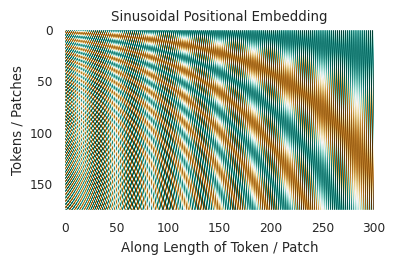

In [6]:
# Example.
PE = get_sinusoidal_encoding(n_tokens=176, token_length=768)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(PE[0, :, 0:301], cmap='BrBG')
ax.set_title('Sinusoidal Positional Embedding')
ax.set_xlabel('Along Length of Token / Patch')
ax.set_ylabel('Tokens / Patches')
ax.grid(alpha=0)
plt.savefig('./misc-figures/sinusoidal-positional-embedding-example.pdf', bbox_inches='tight')

In [13]:
# Sequence-embedding network.
class Embedding(nn.Module):
    def __init__(self, image_size, patch_size, channels, embed_dim):
        super().__init__()
        self.image_size = int(image_size)
        self.patch_size = int(patch_size)
        self.channels = int(channels)
        self.embed_dim = int(embed_dim)
        
        # Trainable linear projection for mapping dimension of patches.
        self.W_E = nn.Parameter(torch.randn(self.patch_size * self.patch_size * self.channels, self.embed_dim))
        
        # Fixed sinusoidal positional embedding.
        self.n_patches = self.image_size ** 2 // self.patch_size ** 2
        self.PE = get_sinusoidal_encoding(n_tokens=self.n_patches, token_length=self.embed_dim)
        
    def forward(self, x):
        # Patching.
        patches = x.unfold(1, self.channels , self.channels).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(patches.size(0), -1, self.channels  * self.patch_size * self.patch_size).float()
        
        # Patch embeddings.
        patch_embeddings = torch.matmul(patches, self.W_E)
        
        # Position embeddings.
        embeddings = patch_embeddings + self.PE
        
        # Transpose so that each column represents a patch embedding.
        embeddings = torch.transpose(embeddings, 1, 2)
        
        return embeddings
    
# Shape check.
channels, image_size, patch_size, embed_dim = 3, 64, 16, 768
embedding_layer = Embedding(image_size, patch_size, channels, embed_dim)
x = torch.randn(batch_size, channels, image_size, image_size)
y = embedding_layer(x)
print(f'Embedding layer: input shape {x.shape} -> output shape {y.shape}')

Embedding layer: input shape torch.Size([16, 3, 64, 64]) -> output shape torch.Size([16, 768, 16])


In [19]:
# Second network (1-D CNN) for producing key's from the embedding.
class KeyProducer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, key_dim, kernel_size, activation_fn):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.key_dim = key_dim
        self.kernel_size = kernel_size
        self.activation = activation_fn
        
        # Convolution for hidden representation.
        self.conv1 = nn.Conv1d(in_channels=self.embed_dim, out_channels=self.hidden_dim, kernel_size=self.kernel_size, padding=)
        
        # Normalisation and pooling.
        self.bn1 = nn.BatchNorm1d(num_features=self.hidden_dim)
        #self.pool1 = nn.MaxPool1d(kernel_size=2) # Maybe fuck off the pooling?
        
        self.layer1 = nn.Sequential(self.conv1, self.bn1, self.activation)
        
        # Convolution for output representation (i.e. keys).
        self.conv2 = nn.Conv1d(in_channels=self.hidden_dim, out_channels=self.key_dim, kernel_size=self.kernel_size)
        
        # Normalisation and pooling.
        self.bn2 = nn.BatchNorm1d(num_features=self.key_dim)
        #self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.layer2 = nn.Sequential(self.conv2, self.bn2, self.activation)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        return x
    
# Shape check.
embed_dim, hidden_dim, key_dim, kernel_size, activation_fn = 768, 384, 192, 3, nn.ReLU()
key_producing_layer = KeyProducer(embed_dim, hidden_dim, key_dim, kernel_size, activation_fn)
x = torch.randn(batch_size, embed_dim, 16)
y = key_producing_layer(x)
print(f'Key Producing layer: input shape {x.shape} -> output shape {y.shape}')

Key Producing layer: input shape torch.Size([16, 768, 16]) -> output shape torch.Size([16, 192, 16])
